## Dynamic Flux Based Analysis

And write write write

In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra import Model, Reaction, Metabolite

In [2]:
model = read_sbml_model('models/iMM904_progesterone.xml')
model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')
model.objective =model.reactions.DM_progesterone_c

In [3]:
# max growth and max progesterone production
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth: {baseline_max_growth} mmol/gDW*h")
print(f"Maximum progesterone production: {baseline_max_production} mmol/gDW*h")

# growth and progesterone production when both are set to be objective
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): 10, 
                    model.reactions.get_by_id('DM_progesterone_c'): 1} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone_production = solution.fluxes['DM_progesterone_c']
    print(f"Growth in complete model: {growth} mmol/gDW*h")
    print(f"Progesterone production in complete model: {progesterone_production} mmol/gDW*h")

Maximum growth: 0.14285714285714288 mmol/gDW*h
Maximum progesterone production: 0.14285714285714285 mmol/gDW*h
Growth in complete model: 0.2878657037040183 mmol/gDW*h
Progesterone production in complete model: 0.0 mmol/gDW*h


In [4]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [5]:
model.demands

[<Reaction DM_progesterone_c at 0x7fd361d12b10>]

In [6]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Pro = KineticVariable("Progesterone")
Oxy = KineticVariable("Oxygen")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro, Oxy])

In [7]:
# instances of ExchangeFlux

mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [8]:
# add rhs expressions for kinetic variables in dfba_model
#ENHEDER?
Vgmax = 8.5
Kg = 0.5
Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X ) #+ D * (Gin - Gluc) / V
dfba_model.add_rhs_expression("Progesterone", v_P * X) # - D * Pro / V

In [9]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [10]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)
#IS THIS TRUE???

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 10.0,
        "Oxygen": 2.0, 
        "Progesterone": 0.01
    }
)

In [11]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_o2_e", "DM_progesterone_c"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 23
Number of residual evaluations     = 70
Number of Jacobian evaluations     = 18
Number of nonlinear iterations     = 33
Number of error test failures      = 2
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 210


Final Run Statistics: 

Number of steps                    = 21
Number of residual evaluations     = 48
Number of Jacobian evaluations     = 13
Number of nonlinear iterations     = 24
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 74


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 2
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 1
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 11


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluat

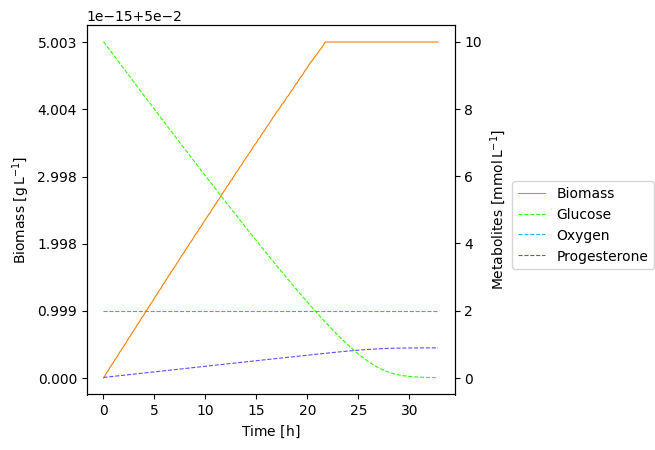

In [12]:
plot_concentrations(concentrations)
#plt.title("Batch fermentation")

In [14]:
concentrations

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.05,10.000000,2.0,0.010000
1,0.1,0.05,9.959527,2.0,0.013339
2,0.2,0.05,9.919064,2.0,0.016678
3,0.3,0.05,9.878609,2.0,0.020017
4,0.4,0.05,9.838154,2.0,0.023356
...,...,...,...,...,...
324,32.4,0.05,0.005226,2.0,0.889370
325,32.5,0.05,0.004804,2.0,0.889385
326,32.6,0.05,0.004415,2.0,0.889395
327,32.7,0.05,0.004057,2.0,0.889403
